In [6]:
import datetime
from enum import Enum
import math
import os
import sys
import typing
from typing import cast

from kneed import KneeLocator
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import adjusted_rand_score
# from sklearn.metrics import accuracy_score, adjusted_rand_score
from sklearn.metrics import (
    calinski_harabasz_score,
    davies_bouldin_score,
    silhouette_score,
)
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    FunctionTransformer,
    MinMaxScaler,
    StandardScaler,
)
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from yellowbrick.features import PCA as PCAViz


In [15]:
dataset = pd.read_csv('./full_dataset.csv', index_col=0, parse_dates=['order_purchase_timestamp'])
dataset

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,...,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,credit_card,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,3.0,voucher,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,2.0,voucher,...,40.0,268.0,4.0,500.0,19.0,8.0,13.0,9350.0,maua,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,1.0,boleto,...,29.0,178.0,1.0,400.0,19.0,13.0,19.0,31570.0,belo horizonte,SP
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,1.0,credit_card,...,46.0,232.0,1.0,420.0,24.0,19.0,21.0,14840.0,guariba,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00,1.0,credit_card,...,52.0,828.0,4.0,4950.0,40.0,10.0,40.0,17602.0,tupa,SP
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00,1.0,credit_card,...,51.0,500.0,2.0,13300.0,32.0,90.0,22.0,8290.0,sao paulo,SP
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1.0,credit_card,...,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,37175.0,ilicinea,MG
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00,1.0,credit_card,...,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,37175.0,ilicinea,MG


In [16]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 99440
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   order_approved_at              118966 non-null  object        
 5   order_delivered_carrier_date   117057 non-null  object        
 6   order_delivered_customer_date  115722 non-null  object        
 7   order_estimated_delivery_date  119143 non-null  object        
 8   payment_sequential             119140 non-null  float64       
 9   payment_type                   119140 non-null  object        
 10  payment_installments           119140 non-null  float64       
 11  p

In [28]:
SELECTED_COLUMNS = ['recency', 'frequency', 'monetary', 'mean_review']

def preprocess(dataset: pd.DataFrame, scale: bool = True, log: bool = True) -> pd.DataFrame:
    """
        Add features engineering to the dataset.

        Parameters:
            dataset: Dataset to preprocess
            scale: Wether to use a StandardScaler on the data
            log: Wether to use a log transformation on data

        Returns:
            Preprocess data
    """

    # Extract RFM data from dataset
    rfm_data = get_rfm(dataset)
    mean_review = get_mean_review(dataset)

    data = pd.concat([rfm_data, mean_review], axis=1)
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler() if scale else 'passthrough')])
    log_features = ['monetary']
    data = data.drop(data[(data[log_features] == 0).any(axis=1)].index)
    data.dropna(inplace = True)
    log_transformer = Pipeline(steps=[('log', FunctionTransformer(np.log) if log else 'passthrough'),
                                      ('numeric', numeric_transformer)])
    preprocessor = log_transformer

    preprocessor.fit(data)
    return pd.DataFrame(preprocessor.transform(data), columns=SELECTED_COLUMNS)

def get_rfm(dataset: pd.DataFrame, time_column: str = 'order_purchase_timestamp', id_column: str = 'customer_unique_id', customer_id_column: str = 'customer_id', price_column: str = 'price') -> pd.DataFrame :
    """
        Get RFM marketing data from input dataset

        Parameters:
            dataset: Dataset to extract RFM data from
            time_column: Name of the column containing time data. Default to `order_purchase_timestamp`
            id_column: Name of the column containing a unique ID. Default to `customer_unique_id`
            customer_id_column: Name of the column containing ordering ID. Default to `customer_id`
            price_column: Name of the column containing price data. Default to `price`

        Returns:
            A DataFrame with recency, frequency and monetary data
    """
    max_date = max(dataset[time_column]) + datetime.timedelta(days=1)
    rfm_data = dataset.groupby(id_column).agg({
            time_column: lambda x: (max_date - x.max()).days,
            customer_id_column: 'count',
            price_column: 'sum'
    })
    rfm_data.columns = ['recency','frequency','monetary']
    return rfm_data

def get_mean_review(dataset: pd.DataFrame, review_column: str = 'review_score', id_column: str = 'customer_unique_id', customer_id_column: str = 'customer_id') -> pd.Series:
    """
        Get mean review for each unique customer

        Parameters:
            dataset: Dataset to extract mean review from
            review_column: Name of the column containing review data. Default to `review_score`
            id_column: Name of the column containing a unique ID. Default to `customer_unique_id`
            customer_id_column: Name of the column containing ordering ID. Default to `customer_id`

        Returns:
            A Series with the mean review for each customer
    """
    mean_review = dataset.dropna(subset=[review_column]).groupby([id_column, customer_id_column])[review_column].first()\
        .groupby(id_column).mean()
    mean_review.name = 'mean_review'
    return mean_review


In [9]:
X = preprocess(dataset)
X

,recency,frequency,monetary,mean_review
0,-0.665646,-0.388352,0.386938,0.576917
1,-0.635866,-0.388352,-1.635922,0.135803
2,1.418232,-0.388352,-0.276985,-0.432892
3,0.676541,-0.388352,-1.301630,0.135803
4,0.525853,-0.388352,0.729249,0.576917
...,...,...,...,...
94716,1.149272,1.654325,3.002155,0.576917
94717,0.396344,-0.388352,-0.341433,0.135803
94718,1.503994,-0.388352,0.000682,0.576917
94719,-0.587424,-0.388352,0.259084,0.576917


In [29]:
def split_periods(dataset: pd.DataFrame, period: int, time_column: str ="order_purchase_timestamp") -> list[pd.DataFrame]:
    """
    Split the dataset into periods based on periods given

        Parameters:
            data (DataFrame): DataFrame to split
            period (int): Number of days for each period
            time_column (str): Column label containing time info. Default to 'total_recency'

        Returns:
            data_periods (DataFrame[]): A list of DataFrame group by period defined by input
    """
    data_periods = []
    delta = datetime.timedelta(period)
    last_threshold = dataset[time_column].min()
    max_date = dataset[time_column].max()
    while(last_threshold < max_date):
        data_periods.append(dataset[(dataset[time_column] >= last_threshold)
                                 & (dataset[time_column] < last_threshold + delta)])
        last_threshold += delta

    return data_periods

In [20]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119143 entries, 0 to 99440
Data columns (total 39 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   order_id                       119143 non-null  object        
 1   customer_id                    119143 non-null  object        
 2   order_status                   119143 non-null  object        
 3   order_purchase_timestamp       119143 non-null  datetime64[ns]
 4   order_approved_at              118966 non-null  object        
 5   order_delivered_carrier_date   117057 non-null  object        
 6   order_delivered_customer_date  115722 non-null  object        
 7   order_estimated_delivery_date  119143 non-null  object        
 8   payment_sequential             119140 non-null  float64       
 9   payment_type                   119140 non-null  object        
 10  payment_installments           119140 non-null  float64       
 11  p

In [30]:
import datetime
from sklearn.metrics import adjusted_rand_score

NB_CLUSTER = 5
periods = split_periods(dataset, 30)
first_period = pd.concat(periods[0:6])
periods = [first_period] + periods[6:]
models = []
Xs = []
for i,_ in enumerate(periods):
    period_data = pd.concat(periods[:i+1])
    
    X = preprocess(period_data)
    period_model = KMeans(n_clusters=NB_CLUSTER, random_state=3)
    period_model.fit(X)

    for model,aris in models:
        ari = adjusted_rand_score(model.predict(X), period_model.labels_)
        aris.append(ari)

    Xs.append(X)
    models.append((period_model, [None] * i))

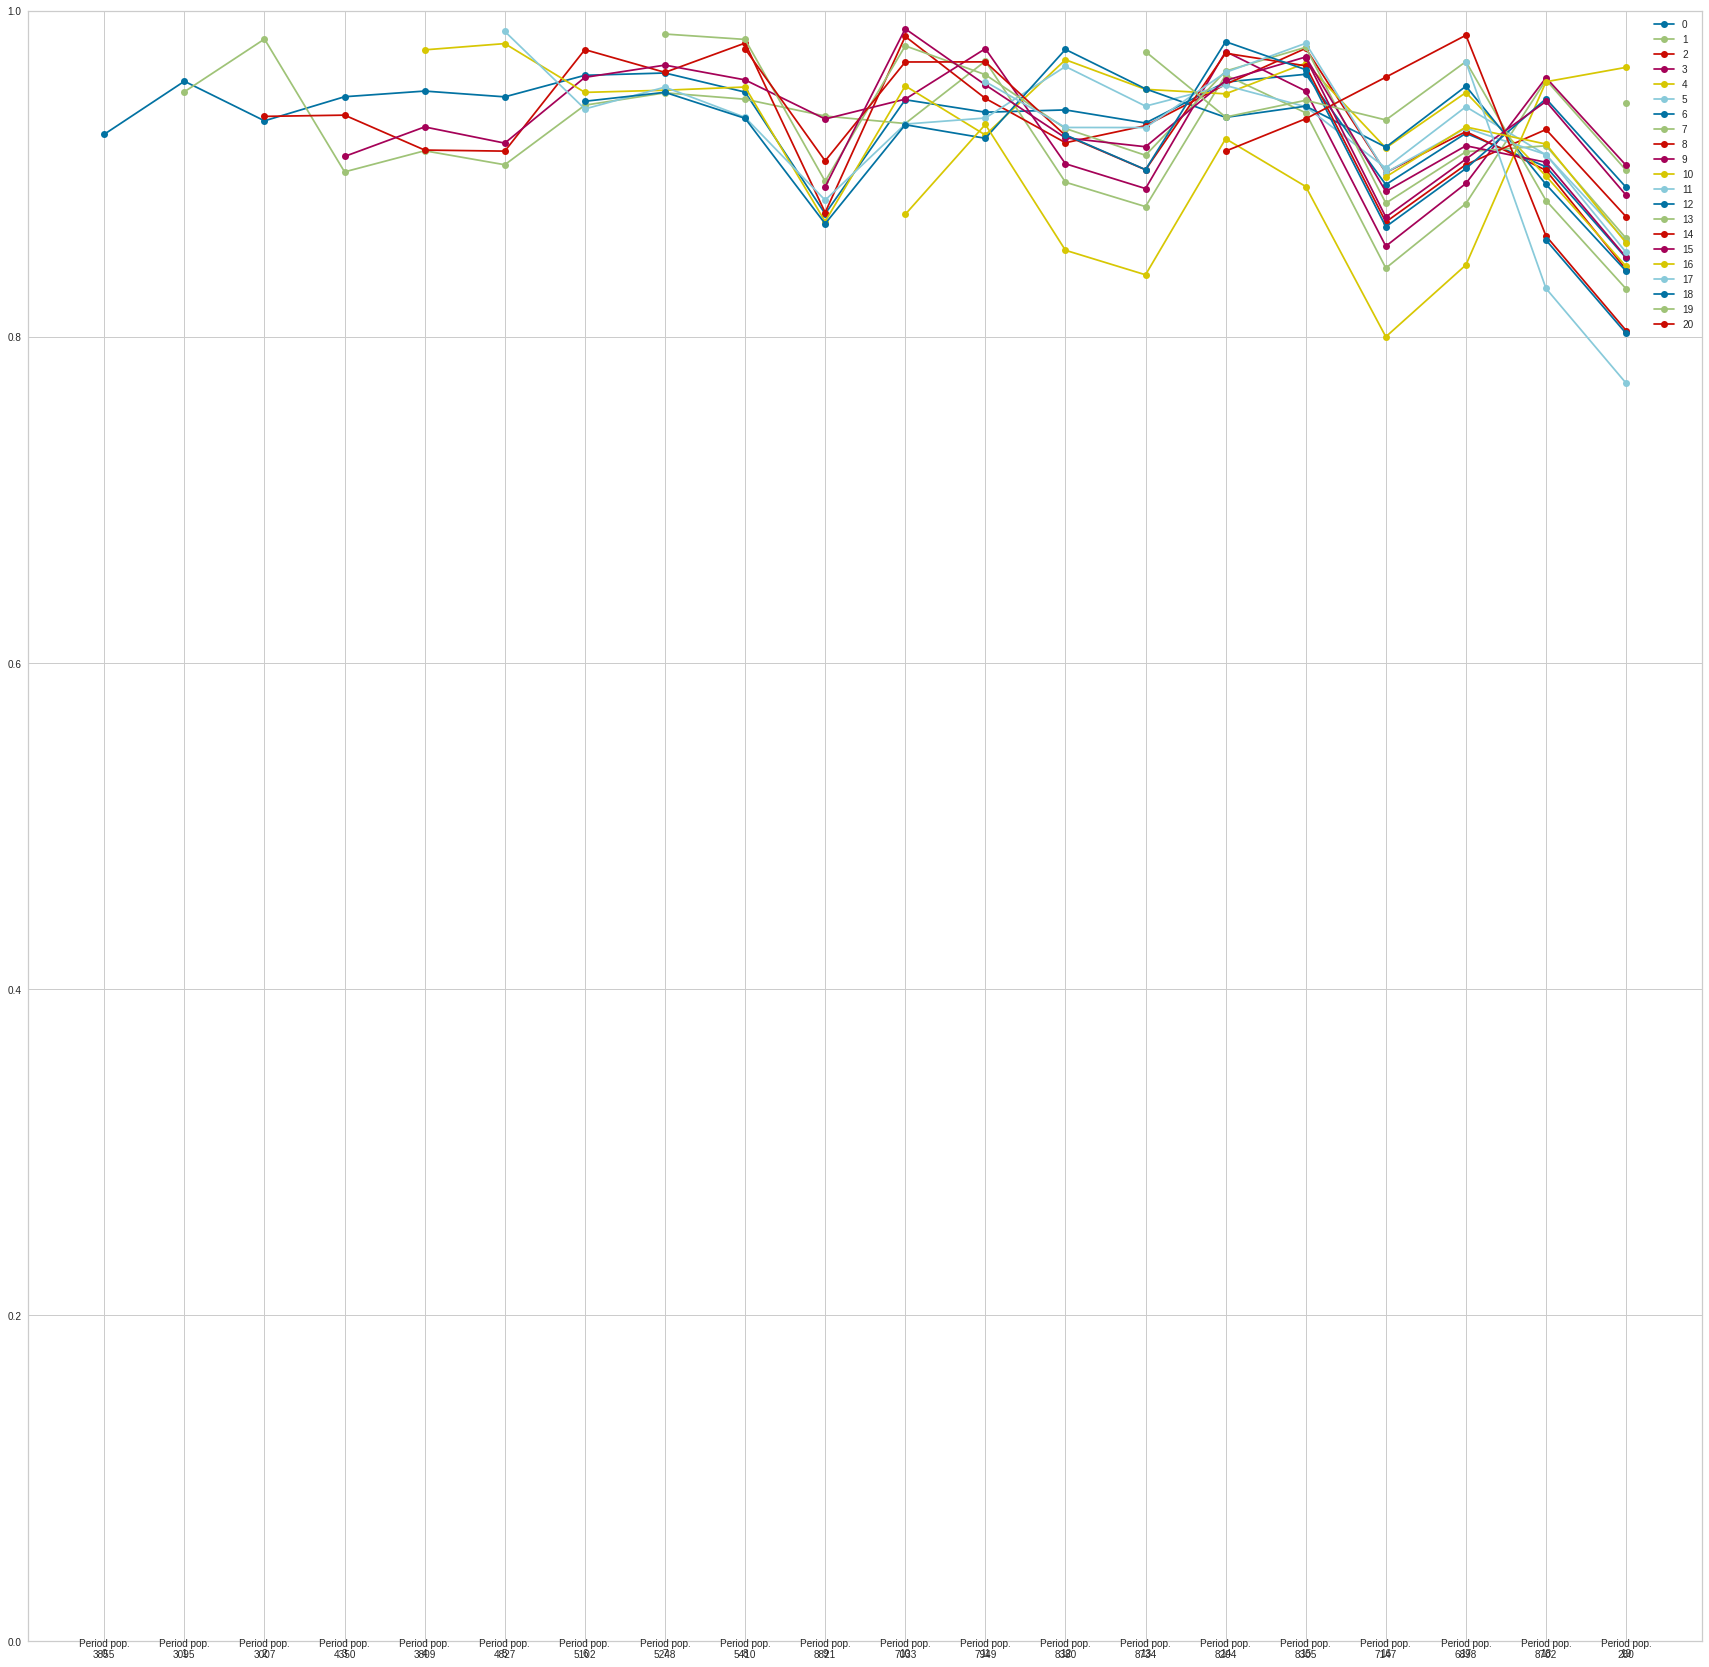

In [35]:
fig, ax = plt.subplots(figsize=(30,30))
periods_index = [i for i,_ in enumerate(periods[1:])]
for model, aris in models:
    plt.plot(periods_index, aris, '-o', figure=fig)
    
ax.set_xticks(periods_index)
for i, xpos in enumerate(ax.get_xticks()):
    ax.text(xpos, -0.01, "Period pop.\n"+str(periods[i].shape[0]), size = 10, ha = 'center')

ax.set_ylim(0, 1)
plt.legend([i for i,_ in enumerate(models)])
plt.show()

In [34]:
from sklearn.metrics import confusion_matrix, accuracy_score
last_labels = None
for i, model in enumerate(models):
    if(isinstance(last_labels, np.ndarray)):
        conf_matrix = confusion_matrix(model[0].labels_[:len(last_labels)], last_labels)
        display(conf_matrix)
        for row in conf_matrix:
            print(row.argmax())
    last_labels = model[0].labels_

array([[ 59, 110,  46, 106,  46],
       [136, 295, 115, 249, 111],
       [ 59, 151,  67, 144,  50],
       [115, 260, 113, 268, 111],
       [ 47, 111,  46,  98,  48]])

1
1
1
3
1


array([[223, 522, 281, 487, 216],
       [220, 463, 291, 486, 207],
       [ 65, 200, 113, 188,  85],
       [ 81, 237, 115, 208,  83],
       [ 76, 191, 115, 206,  74]])

1
3
1
1
3


array([[723, 756, 293, 313, 283],
       [303, 281, 107, 142, 117],
       [741, 680, 265, 325, 285],
       [286, 246, 120, 132, 131],
       [428, 412, 172, 154, 157]])

1
0
0
0
0


array([[ 374,  158,  361,  169,  212],
       [1092,  465, 1040,  416,  618],
       [1000,  411, 1013,  408,  559],
       [ 443,  183,  408,  142,  226],
       [ 485,  189,  440,  181,  282]])

0
0
2
0
0


array([[ 252,  716,  691,  280,  330],
       [ 534, 1376, 1372,  568,  663],
       [ 504, 1410, 1257,  518,  548],
       [ 183,  562,  548,  229,  251],
       [ 164,  509,  456,  200,  207]])

1
1
1
1
1


array([[ 441,  811,  785,  325,  314],
       [ 295,  612,  562,  206,  197],
       [ 848, 1725, 1619,  697,  558],
       [ 363,  737,  654,  279,  251],
       [ 891, 1746, 1744,  746,  635]])

1
1
1
1
1


array([[ 314,  240,  699,  262,  727],
       [ 443,  315,  809,  372,  885],
       [1073,  748, 2172,  892, 2214],
       [ 434,  334,  953,  410, 1034],
       [ 976,  698, 2027,  872, 2118]])

4
4
4
4
4


array([[ 299,  344,  846,  389,  794],
       [ 761,  979, 2534, 1155, 2366],
       [ 880, 1090, 2703, 1168, 2532],
       [ 350,  452, 1102,  446,  986],
       [ 421,  498, 1249,  557, 1215]])

2
2
2
2
2


array([[ 960, 2829, 3007, 1215, 1383],
       [ 352,  928, 1079,  403,  504],
       [ 425, 1108, 1305,  517,  575],
       [ 389, 1196, 1197,  490,  623],
       [1022, 2962, 3123, 1259, 1454]])

2
2
2
2
2


array([[3203, 1086, 1329, 1359, 3303],
       [2256,  794,  973,  960, 2371],
       [1471,  501,  613,  598, 1625],
       [3229, 1235, 1397, 1346, 3459],
       [1254,  436,  555,  521, 1291]])

4
4
4
4
4


array([[3636, 2586, 1779, 3738, 1446],
       [3841, 2857, 1755, 3957, 1541],
       [1539, 1046,  700, 1536,  607],
       [1306,  919,  599, 1429,  502],
       [1500, 1075,  712, 1617,  629]])

3
3
0
3
3


array([[4754, 4985, 1971, 1751, 1955],
       [4515, 4690, 1838, 1631, 1948],
       [1915, 2088,  787,  710,  752],
       [1733, 1858,  696,  623,  727],
       [2208, 2362,  946,  807,  949]])

1
1
1
1
1


array([[5506, 5277, 2209, 2016, 2641],
       [2250, 2157,  944,  805, 1047],
       [2245, 2068,  904,  796, 1019],
       [2149, 2077,  830,  803, 1011],
       [5352, 5017, 2214, 2033, 2488]])

0
0
0
0
0


array([[2401, 1009, 1016, 1008, 2394],
       [6224, 2615, 2512, 2493, 6138],
       [2523, 1006,  956,  924, 2362],
       [6244, 2487, 2402, 2385, 5928],
       [2439,  998, 1004,  957, 2401]])

0
0
0
0
0


array([[1328, 3340, 1315, 3172, 1336],
       [2659, 6827, 2680, 6715, 2746],
       [2486, 6421, 2554, 6204, 2486],
       [1100, 2777, 1067, 2723, 1003],
       [1056, 2705, 1027, 2647, 1053]])

1
1
1
1
1


array([[3506, 7012, 6635, 2834, 2791],
       [3604, 7613, 7005, 3097, 2920],
       [1492, 3224, 3001, 1281, 1287],
       [1434, 2805, 2622, 1113, 1163],
       [1498, 3000, 2788, 1130, 1173]])

1
1
1
1
1


array([[2675, 2828, 1150, 1049, 1093],
       [8143, 8736, 3811, 3257, 3378],
       [7716, 8150, 3438, 3125, 3200],
       [3108, 3222, 1365, 1274, 1350],
       [2846, 3124, 1298, 1158, 1240]])

1
1
1
1
1


array([[2886, 8756, 8298, 3312, 3177],
       [1152, 3612, 3395, 1426, 1280],
       [1068, 3378, 3227, 1299, 1195],
       [1289, 3918, 3611, 1448, 1354],
       [2990, 9543, 8881, 3490, 3371]])

1
1
1
1
1


array([[8429, 3440, 3184, 3679, 8905],
       [5356, 2164, 2077, 2321, 5794],
       [7898, 3306, 3114, 3567, 8594],
       [3375, 1360, 1302, 1376, 3567],
       [3553, 1449, 1376, 1594, 3751]])

4
4
4
4
4


array([[ 1435, 17578,  1527,    32,     2],
       [    0,     0, 24997,    24,     0],
       [    6,     1,     8, 10918,     1],
       [    3,   159,     0,     5, 11721],
       [26251,     0,     5,    25,    23]])

1
2
3
4
0


In [52]:
from sklearn.metrics import v_measure_score
y_pred = models[0][0].predict(Xs[1])
y_true = models[1][0].labels_
print(f'Accuracy: {accuracy_score(y_pred, y_true)}')
print(f'ARI: {adjusted_rand_score(y_pred, y_true)}')
print(f'V-mesure: {v_measure_score(y_pred, y_true)}')

Accuracy: 0.5773973863427204
ARI: 0.9242371921985044
V-mesure: 0.9154249853930156


In [85]:
def switch(number, replacement):
    return lambda x: replacement if x == number else 0

conf_matrix = confusion_matrix(y_pred, y_true)
display(conf_matrix)
rows = []
for i, row in enumerate(conf_matrix):
    argmax = row.argmax()
    print(f'{i} => {argmax}')
    copy = y_pred.copy()
#    copy[copy != i] = -1
 #   copy[copy == i] = argmax
  #  copy[copy == -1] = 0
    rows.append(np.where(copy == i, argmax, 0))

print(y_pred)
print(rows)
matched = np.array(rows).sum(axis=0)
print(matched)
accuracy_score(matched, y_true)

array([[   1,    0,  815,    5,    1],
       [   2, 1573,   78,    1,    0],
       [   0,    0,    0,    6,  664],
       [   0,   40,   18, 1563,    0],
       [ 662,    0,    4,    0,    0]])

0 => 2
1 => 1
2 => 4
3 => 3
4 => 0
[1 3 1 ... 2 0 3]
[array([0, 0, 0, ..., 0, 2, 0]), array([1, 0, 1, ..., 0, 0, 0]), array([0, 0, 0, ..., 4, 0, 0]), array([0, 3, 0, ..., 0, 0, 3]), array([0, 0, 0, ..., 0, 0, 0])]
[1 3 1 ... 4 2 3]


0.9712865819988956

In [78]:
my_array = np.array([0,1,2])

np.where(my_array == 0, 1,0)

array([1, 0, 0])

In [67]:
arr = np.array(([0,1,2], [0,1,2]))
arr.sum(axis=1)
arr + 1

array([[1, 2, 3],
       [1, 2, 3]])

# TODO
* Faire le graph silhouette a la main https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
* Regarder le MinMax pour l'ARI
* Boxplot de chaque variable par période
* Analyze univariée + comparaison log/std/rien